# Description

Notebook implementing RDD search by directly optimizing for the first stage of a local linear regression.

# Imports

In [59]:
import numpy as np
import pandas as pd
from linearmodels.iv import IV2SLS
import seaborn as sns
import matplotlib.pyplot as plt
from rdd import rdd

from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')


In [2]:
# separate out rpy2 imports
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

rdrobust = importr("rdrobust")
r_rdd = importr("rdd")

# activate automatic pandas to R for this session
pandas2ri.activate()

In [3]:
# only needs to be done once
utils = importr('utils')

# install R packages if needed
#utils.install_packages("rdd")

In [4]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


# Functions

In [5]:
def gen_fuzzy_rdd(n_samples, fuzzy_gap, tau, take=0.0, seed=0, boundary=0.5):
    """
    Builds a fuzzy RDD with imperfect compliance.
    
    p is the "true" probability of getting treatment, and is a function of x and the unknown covariate u.
    
    Params:
        n_samples (int): number of samples to draw
        fuzzy_fuzzy_gap (float): the fuzzy_gap in treatment probability, centered at 0.5. Max value is 1, and induces a sharp RDD.
        tau (float): the treatment effect on the outcome
        take (float): the coefficient for probability of taking treatment, defaults to 0.2
        seed (int): seed for reproducibility
        
    Returns:
        df (pd.DataFrame): pandas Dataframe with x,y,t,z,u,p populated (note, do not use u, p in regression)
    """
    np.random.seed(seed)
    
    # observed covariates
    x = np.random.uniform(0, 1, n_samples)

    # unobserved confounder
    #u = np.random.uniform(-.1, 0.1, n_samples)
    u = np.random.normal(0, 0.1, n_samples)

    # boundary
    b = boundary

    # boundary indicator
    d = (x > b).astype(int)

    gamma_p = np.random.normal(0, 1, 1)
    noise_p = np.random.normal(0, 1, n_samples)

    
    mu = d*(0.5 + fuzzy_gap/2) + (1-d)*(0.5 - fuzzy_gap/2)
    #print(mu)
    p_take = take*x - take/2 + u #(fuzzy_gap/2)

    p_adj = mu + p_take
    p_adj = np.clip(p_adj, 0,1)

    # treatment indicator
    t = np.random.binomial(1, p_adj, n_samples)
    
    # outcome and treatment
    gamma_y = np.random.normal(0, 1, 1)
    noise_y = np.random.normal(0, 1, n_samples)
    y = x*gamma_y + t*tau + noise_y #+ u
    
    df = pd.DataFrame()
    df['x'] = x # running variable
    df['z'] = d # indicator for above/below threshold
    df['t'] = t # indicator for actual treatment assignment
    df['y'] = y # outcome
    df['p'] = p_adj # true probability of treatment
    df['u'] = u # "unobserved" covariate
    
    df['x_lower'] = (1-df['z'])*(df['x'] - 0.5) # adjusted x for 2SLS
    df['x_upper'] = df['z']*(df['x'] - 0.5) # adjusted x for 2SLS
    df['p_compliance'] = (df['z']*df['p']) + (1-df['z'])*(1-df['p']) # probability of compliance
    
    return df
    
def point_plot(x, target, df, scale, errwidth=0):
    sns.pointplot(x=np.floor(df[x]*scale) / scale, y=df[target], join=False, errwidth=errwidth)
    plt.xticks(np.arange(0,scale+1,scale/10), [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Validate first stage procedure

First we double-check equivalence between TSLS and standard FRDD estimates. This is to ensure that we can use the first stage TSLS (a modified OLS) to estimate the first stage of the FRDD.

## Simulated data

In [6]:
n = 1000
test_df = gen_fuzzy_rdd(n, 0.8, 0.8, 0.2, seed=0)

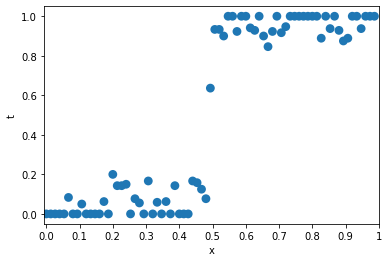

In [7]:
scale = 75
point_plot('x', 't', test_df, scale, errwidth=0)

## Uniform kernel, fixed bandwidth

### TSLS estimate from linearmodels

In [8]:
formula = 'y ~ 1 + x_lower + x_upper + [t ~ z]'
iv_model = IV2SLS.from_formula(formula, test_df)
iv_results = iv_model.fit(cov_type='robust')
display(iv_results)

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                      y   R-squared:                      0.0482
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0453
No. Observations:                1000   F-statistic:                    39.525
Date:                Thu, Jun 24 2021   P-value (F-stat)                0.0000
Time:                        12:53:00   Distribution:                  chi2(3)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -0.7216     0.1008    -7.1614     0.0000     -0.9191     -0.5241
x_lower       -1.5882     0.3238    -4.9052     0.0000     -2.2227     -0.9536
x_upper       -1.2730     0.3078    -4.1360     0.0000     -1.8763     -0.6698
t              0.8705     0.1477     5.8927     0.0000      0.5809      1.1600
==============================================================================

Endogenous: t
Instruments: z
Robust Covariance (Heteroskedastic)
Debiased: False
IVResults, id: 0x7f3def2af110

#### extract first stage results

In [9]:
iv_results.first_stage.individual['t']

OLS Estimation Summary                            
==============================================================================
Dep. Variable:                      t   R-squared:                      0.8223
Estimator:                        OLS   Adj. R-squared:                 0.8218
No. Observations:                1000   F-statistic:                    5560.5
Date:                Thu, Jun 24 2021   P-value (F-stat)                0.0000
Time:                        12:53:00   Distribution:                  chi2(3)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.0961     0.0225     4.2656     0.0000      0.0519      0.1403
x_lower        0.1694     0.0655     2.5848     0.0097      0.0409      0.2978
x_upper        0.0559     0.0585     0.9561     0.3390     -0.0587      0.1705
z              0.8502     0.0294     28.894     0.0000      0.7925      0.9079
==============================================================================
OLSResults, id: 0x7f3e02d88210

In [10]:
# check equivalency with ordinary OLS
from linearmodels.iv.model import _OLS
ols_formula = 't ~ 1 + x_lower + x_upper + z'
ols_results = _OLS.from_formula(ols_formula, test_df).fit(cov_type="robust")
ols_results

OLS Estimation Summary                            
==============================================================================
Dep. Variable:                      t   R-squared:                      0.8223
Estimator:                        OLS   Adj. R-squared:                 0.8218
No. Observations:                1000   F-statistic:                    5560.5
Date:                Thu, Jun 24 2021   P-value (F-stat)                0.0000
Time:                        12:53:00   Distribution:                  chi2(3)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.0961     0.0225     4.2656     0.0000      0.0519      0.1403
x_lower        0.1694     0.0655     2.5848     0.0097      0.0409      0.2978
x_upper        0.0559     0.0585     0.9561     0.3390     -0.0587      0.1705
z              0.8502     0.0294     28.894     0.0000      0.7925      0.9079
==============================================================================
OLSResults, id: 0x7f3ded152890

### FRDD estimate from rdrobust

In [11]:
# in order for TSLS to be equivalent, need to have uniform kernel

rdrob_results = rdrobust.rdrobust(
    y=test_df['y'],
    x=test_df['x'],
    fuzzy=test_df['t'],
    deriv=0,
    c=0.5,
    p=1,
    h=1,                    
    rho=1,
    b=1,
    kernel='uniform',
    vce='hc0',
)

Three results given below are:

1. conventional RDD estimates conventional standard errors
2. bias-corrected estimates with conventional standard errors
3. bias-corrected estimates with robust standard errors

In [12]:
rdrob_taus = np.array(rdrob_results.rx['coef']).squeeze()
rdrob_taus

array([0.87045469, 0.87616476, 0.87616476])

In [13]:
rdrob_se = np.array(rdrob_results.rx['se']).squeeze()

The TSLS estimator is equivalent to the conventional RDD estimates with conventional std errors (the first element):

In [14]:
print("linearmodels TSLS estimate: {:.3f} +/- {:.3f}".format(iv_results.params['t'], iv_results.std_errors['t']))
print("rdrobust FRDD estimate: {:.3f} +/- {:.3f}".format(rdrob_taus[0], rdrob_se[0]))

linearmodels TSLS estimate: 0.870 +/- 0.148
rdrobust FRDD estimate: 0.870 +/- 0.148


In [15]:
assert np.isclose(iv_results.params['t'], rdrob_taus[0])
assert np.isclose(iv_results.std_errors['t'], rdrob_se[0])

## Data-driven bandwidth

- **TODO** test whether fixed bandwidth, triangular kernel is equivalent

In [16]:
ik_bw = r_rdd.IKbandwidth(test_df['x'], 
                        test_df['t'],
                        cutpoint=0.5,
                        verbose=True)

Imbens-Kalyanamaran Optimal Bandwidth:  0.402 


In [17]:
# rdrob_bw = rdrobust.rdbwselect_2014(
#     y=test_df['t'],
#     x=test_df['x'],
#     #fuzzy=test_df['t'],
#     bwselect='IK',
#     vce='resid',
#     c=0.5,
#     rho=1
#     #scaleregul=0
#     #kernel='triangular'
# )

# print(np.array(rdrob_bw.rx('bws')))
# print(np.array(rdrob_bw.rx('bwselect')))

In [18]:
rdd_bw = rdd.optimal_bandwidth(test_df['t'],
                      test_df['x'],
                      cut=0.5)
print("IK optimal bandwidth from rdd python package: {:.3f}".format(rdd_bw))

IK optimal bandwidth from rdd python package: 0.402


Seems to be agreement between the Python implementation and r_rdd implementation (when using a triangular kernel)

# Search procedure

In [19]:
def test_discontinuity(df, cutoff, bw=None):
    """
    Tests whether there is a discontinuity present at the cutoff.
    
    Pre: df has 'x' and 't' columns
    
    Assumes a uniform kernel, for now.
    
    Returns
        (t-stat, p-val, n) of first stage regression
    """
    
    
    if bw is None:
        bw = rdd.optimal_bandwidth(df['t'],
                                   df['x'],
                                   cut=cutoff)
    
    # exclude data
    sel_df = df[(df['x'] < cutoff + bw) & (df['x'] > cutoff - bw)].copy()
    
    # generate covariates needed for first stage regression
    sel_df['z'] = (sel_df['x'] >= cutoff).astype(int)
    sel_df['x_lower'] = (1-sel_df['z'])*(sel_df['x'] - cutoff) # adjusted x for 2SLS
    sel_df['x_upper'] = sel_df['z']*(sel_df['x'] - cutoff) # adjusted x for 2SLS

    ols_formula = 't ~ 1 + x_lower + x_upper + z'
    ols_results = _OLS.from_formula(ols_formula, sel_df).fit(cov_type="robust")
    
    return ols_results.tstats['z'], ols_results.pvalues['z'], sel_df.shape[0]
    

## Simulated data

In [20]:
%%time
cutoffs = np.arange(0.05, 0.96, 0.01)

pvals = []
tstats = []
ns = []
for c in cutoffs:
    t, p, n = test_discontinuity(test_df, c)
    tstats.append(t)
    pvals.append(p)
    ns.append(n)

CPU times: user 58.7 s, sys: 1.71 s, total: 1min
Wall time: 7.56 s


Text(0.5, 0.98, 'First stage regression search results')

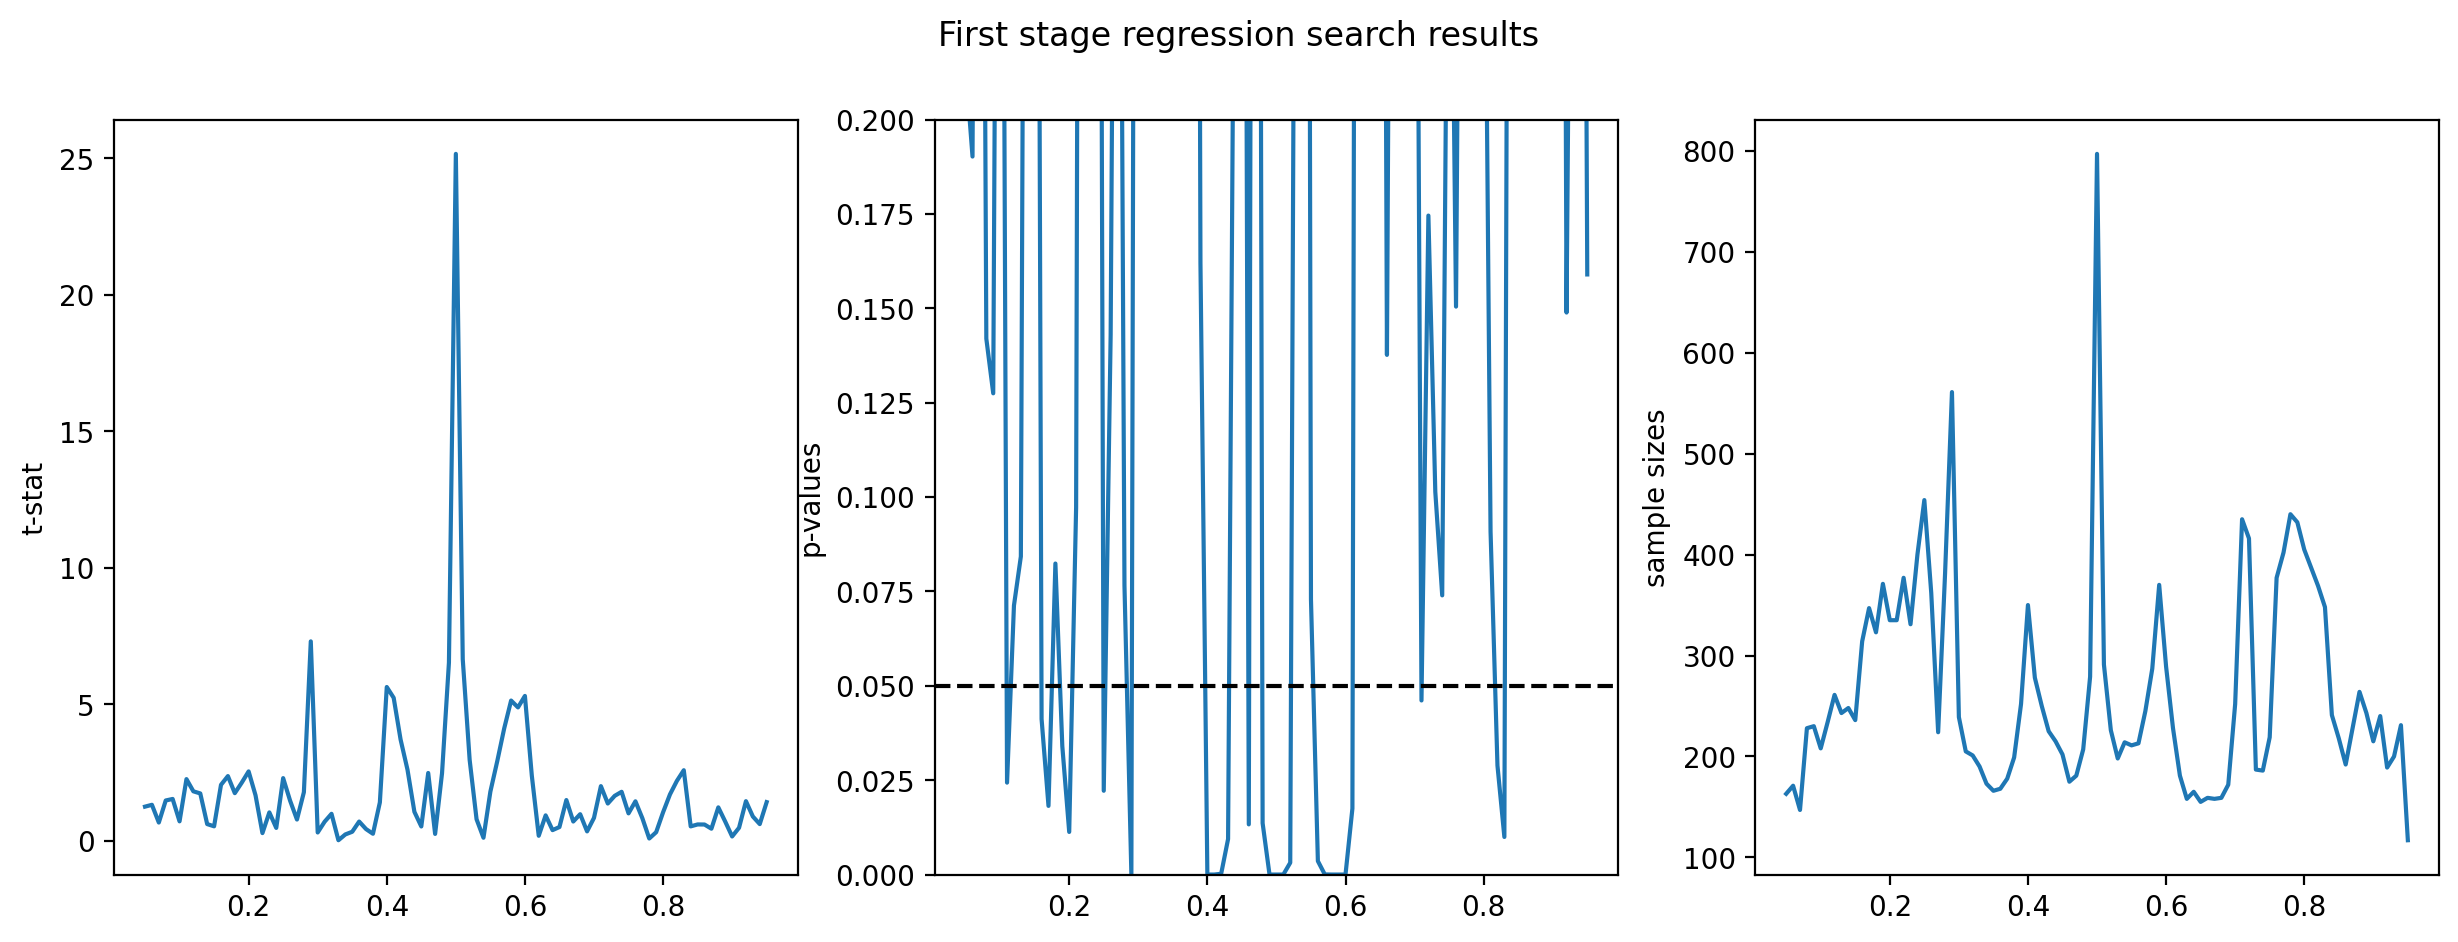

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5), dpi=200)

sns.lineplot(cutoffs, np.abs(tstats), ax=ax1)
ax1.set_ylabel("t-stat")
sns.lineplot(cutoffs, pvals, ax=ax2)
ax2.set_ylabel("p-values")
ax2.set_ylim(0, 0.2)
ax2.axhline(y=0.05, ls='--', color='black')
sns.lineplot(cutoffs, ns, ax=ax3)
ax3.set_ylabel("sample sizes")
fig.suptitle("First stage regression search results")

Directly optimizing for the first stage clearly yields the correct discontinuity at 0.5. We will need an alternative method for generating critical values/p-values on testing with multiple comparisons correction.

## 1D search procedure on ED data

## Load data

The running variables and outcomes are according to the setup from Herlands et al. Note here that the running variable is the number of months to an individual's 23rd birthday for private insurance, hence the possibility of negative values (younger than 23).

In [22]:
ed_df = pd.read_csv("../data/ED_visits/P03_ED_Analysis_File.csv")

In [23]:
ed_df[['priv_all', 'self_all']].describe()

,priv_all,self_all
count,161.000000,161.000000
mean,0.398889,0.260835
std,0.066988,0.064214
min,0.341551,0.106543
25%,0.355039,0.261868
50%,0.371147,0.284556
75%,0.396957,0.304067
max,0.564645,0.322598


In [24]:
ed_df['x'] = ed_df['months_23']
ed_df['t'] = ed_df['priv_all']

In [29]:
ed_df.describe()

,months_23,all,medi_all,priv_all,self_all,o_ins_all,all_pub,medi_all_pub,priv_all_pub,self_all_pub,...,male_non_prof_r,male_for_prof_r,male_other_r,male_l,male_pub_l,male_non_prof_l,male_for_prof_l,male_other_l,x,t
count,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,...,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000
mean,0.000000,97372.006211,0.246414,0.398889,0.260835,0.093862,12755.931677,0.272342,0.278907,0.312512,...,2032.130141,249.222608,33.150466,10.588510,8.640562,10.304482,8.204539,6.186485,0.000000,0.398889
std,46.620811,8109.875513,0.019928,0.066988,0.064214,0.023236,1212.247516,0.039270,0.057125,0.059221,...,83.329227,16.543522,2.542413,0.047757,0.083250,0.041653,0.068956,0.079578,46.620811,0.066988
min,-80.000000,73942.000000,0.218930,0.341551,0.106543,0.044657,9233.000000,0.225516,0.225422,0.167920,...,1814.947466,202.385984,25.085800,10.449265,8.387768,10.192306,7.998671,5.910797,-80.000000,0.341551
25%,-40.000000,93325.000000,0.231556,0.355039,0.261868,0.076407,12043.000000,0.244475,0.241994,0.316630,...,1983.477817,240.592542,31.680171,10.556438,8.593043,10.281102,8.171599,6.144186,-40.000000,0.355039
50%,0.000000,100745.000000,0.238661,0.371147,0.284556,0.106169,13265.000000,0.250365,0.255941,0.332692,...,2053.364545,254.189181,33.515717,10.600926,8.665786,10.315730,8.226573,6.200509,0.000000,0.371147
75%,40.000000,103571.000000,0.258417,0.396957,0.304067,0.111922,13614.000000,0.308997,0.279287,0.351544,...,2088.239926,260.103720,34.807398,10.623155,8.706490,10.332572,8.249575,6.238325,40.000000,0.396957
max,80.000000,106858.000000,0.286666,0.564645,0.322598,0.117022,14204.000000,0.347367,0.421679,0.373756,...,2222.030862,277.167503,38.682440,10.678975,8.759826,10.394672,8.313117,6.343880,80.000000,0.564645


## Procedure

**note**: because of the weirdness in the ED data (only n=160), a fixed bandwidth is needed to ensure the first stage regression is well-defined

In [25]:
%%time
ed_cutoffs = np.arange(-70, 70, 1)

ed_pvals = []
ed_tstats = []
ed_ns = []
for c in ed_cutoffs:
    t, p, n = test_discontinuity(ed_df, c, bw=5)
    ed_tstats.append(t)
    ed_pvals.append(p)
    ed_ns.append(n)

CPU times: user 2.16 s, sys: 0 ns, total: 2.16 s
Wall time: 2.16 s


Text(0.5, 0.98, 'First stage regression search results')

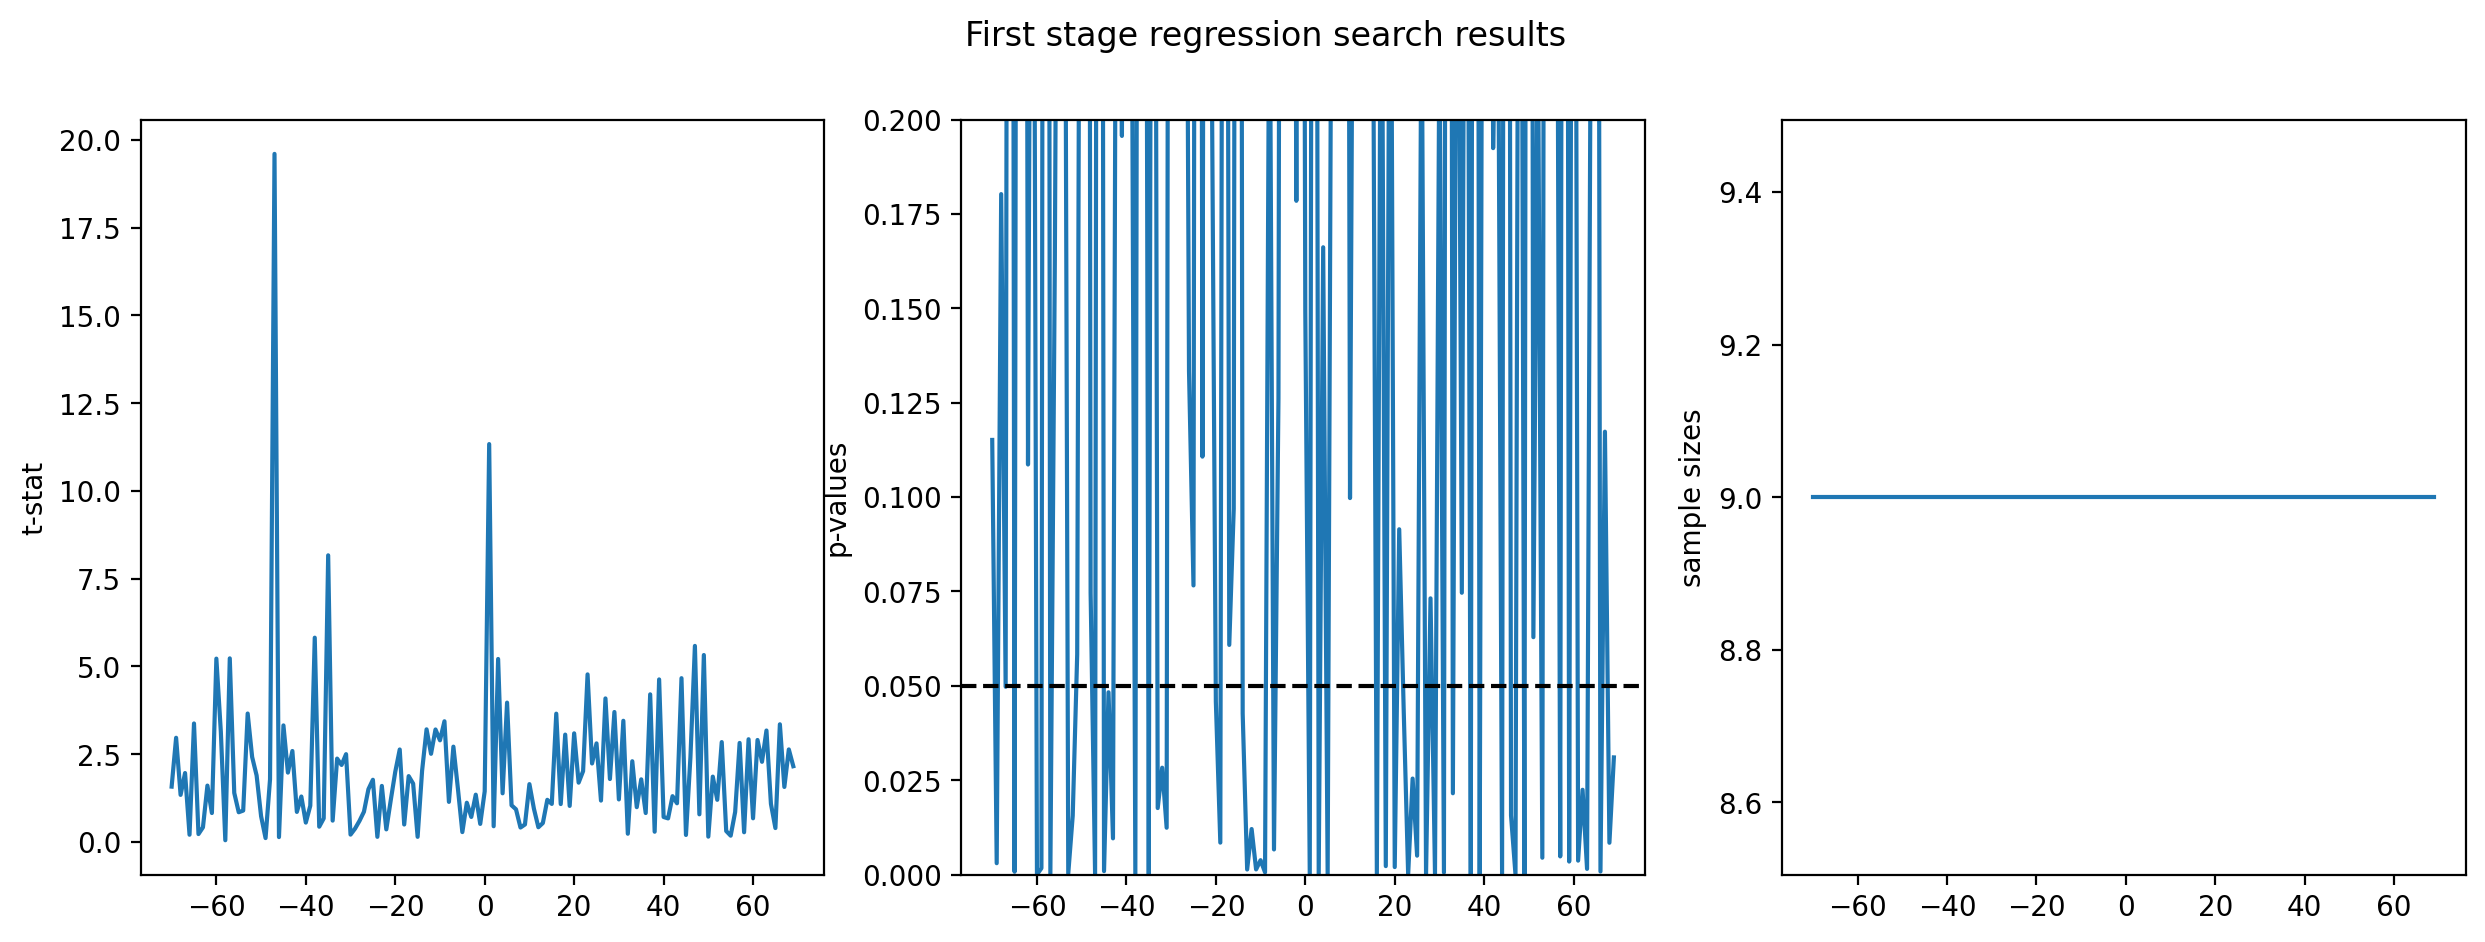

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5), dpi=200)

sns.lineplot(ed_cutoffs, np.abs(ed_tstats), ax=ax1)
ax1.set_ylabel("t-stat")
sns.lineplot(ed_cutoffs, ed_pvals, ax=ax2)
ax2.set_ylabel("p-values")
ax2.set_ylim(0, 0.2)
ax2.axhline(y=0.05, ls='--', color='black')
sns.lineplot(ed_cutoffs, ed_ns, ax=ax3)
ax3.set_ylabel("sample sizes")
fig.suptitle("First stage regression search results")

In [27]:
print("'best' cutoff at {:.2f} yrs".format(23 + (ed_cutoffs[np.argmax(np.abs(ed_tstats))])/ 12))

'best' cutoff at 19.08 yrs


In [28]:
print("Top five candidate cutoffs")
sorted_idxs = np.flip(np.argsort(np.abs(ed_tstats)))
for c in ed_cutoffs[sorted_idxs][:5]:
    print("{:.2f} yrs".format(23 + (c)/ 12))

Top five candidate cutoffs
19.08 yrs
23.08 yrs
20.08 yrs
19.83 yrs
26.92 yrs


- Compare these results to Table 4, "private insurance" column of the Herlands et al. paper.
- Top two candidate RDDs found here look to be 19 yrs and 23 yrs, a subset of the discontinuities found by LORD3.
- Again, there is weirdness in the data (why are the individuals aggregated according to their running variable instead of having the data in the "long" format?) that make us take the results here, and in the Herlands paper, with a grain of salt

# 2021-07-05 Blended RDD simulation

## Generate data

In [41]:
n = 500
df1 = gen_fuzzy_rdd(n, 0.8, 0.8, 0.2, seed=0, boundary=0.4)
df2 = gen_fuzzy_rdd(n, 0.8, 0.8, 0.2, seed=0, boundary=0.6)

df1['cat'] = 1
df2['cat'] = 0

blend_df = df1.append(df2)
blend_df = blend_df.sample(frac=1).reset_index(drop=True)

## Find candidate cutoffs

In [42]:
%%time
cutoffs = np.arange(0.05, 0.96, 0.01)

pvals = []
tstats = []
ns = []
for c in cutoffs:
    t, p, n = test_discontinuity(blend_df, c)
    tstats.append(t)
    pvals.append(p)
    ns.append(n)

CPU times: user 1min, sys: 1.41 s, total: 1min 1s
Wall time: 7.75 s


Text(0.5, 0.98, 'First stage regression search results')

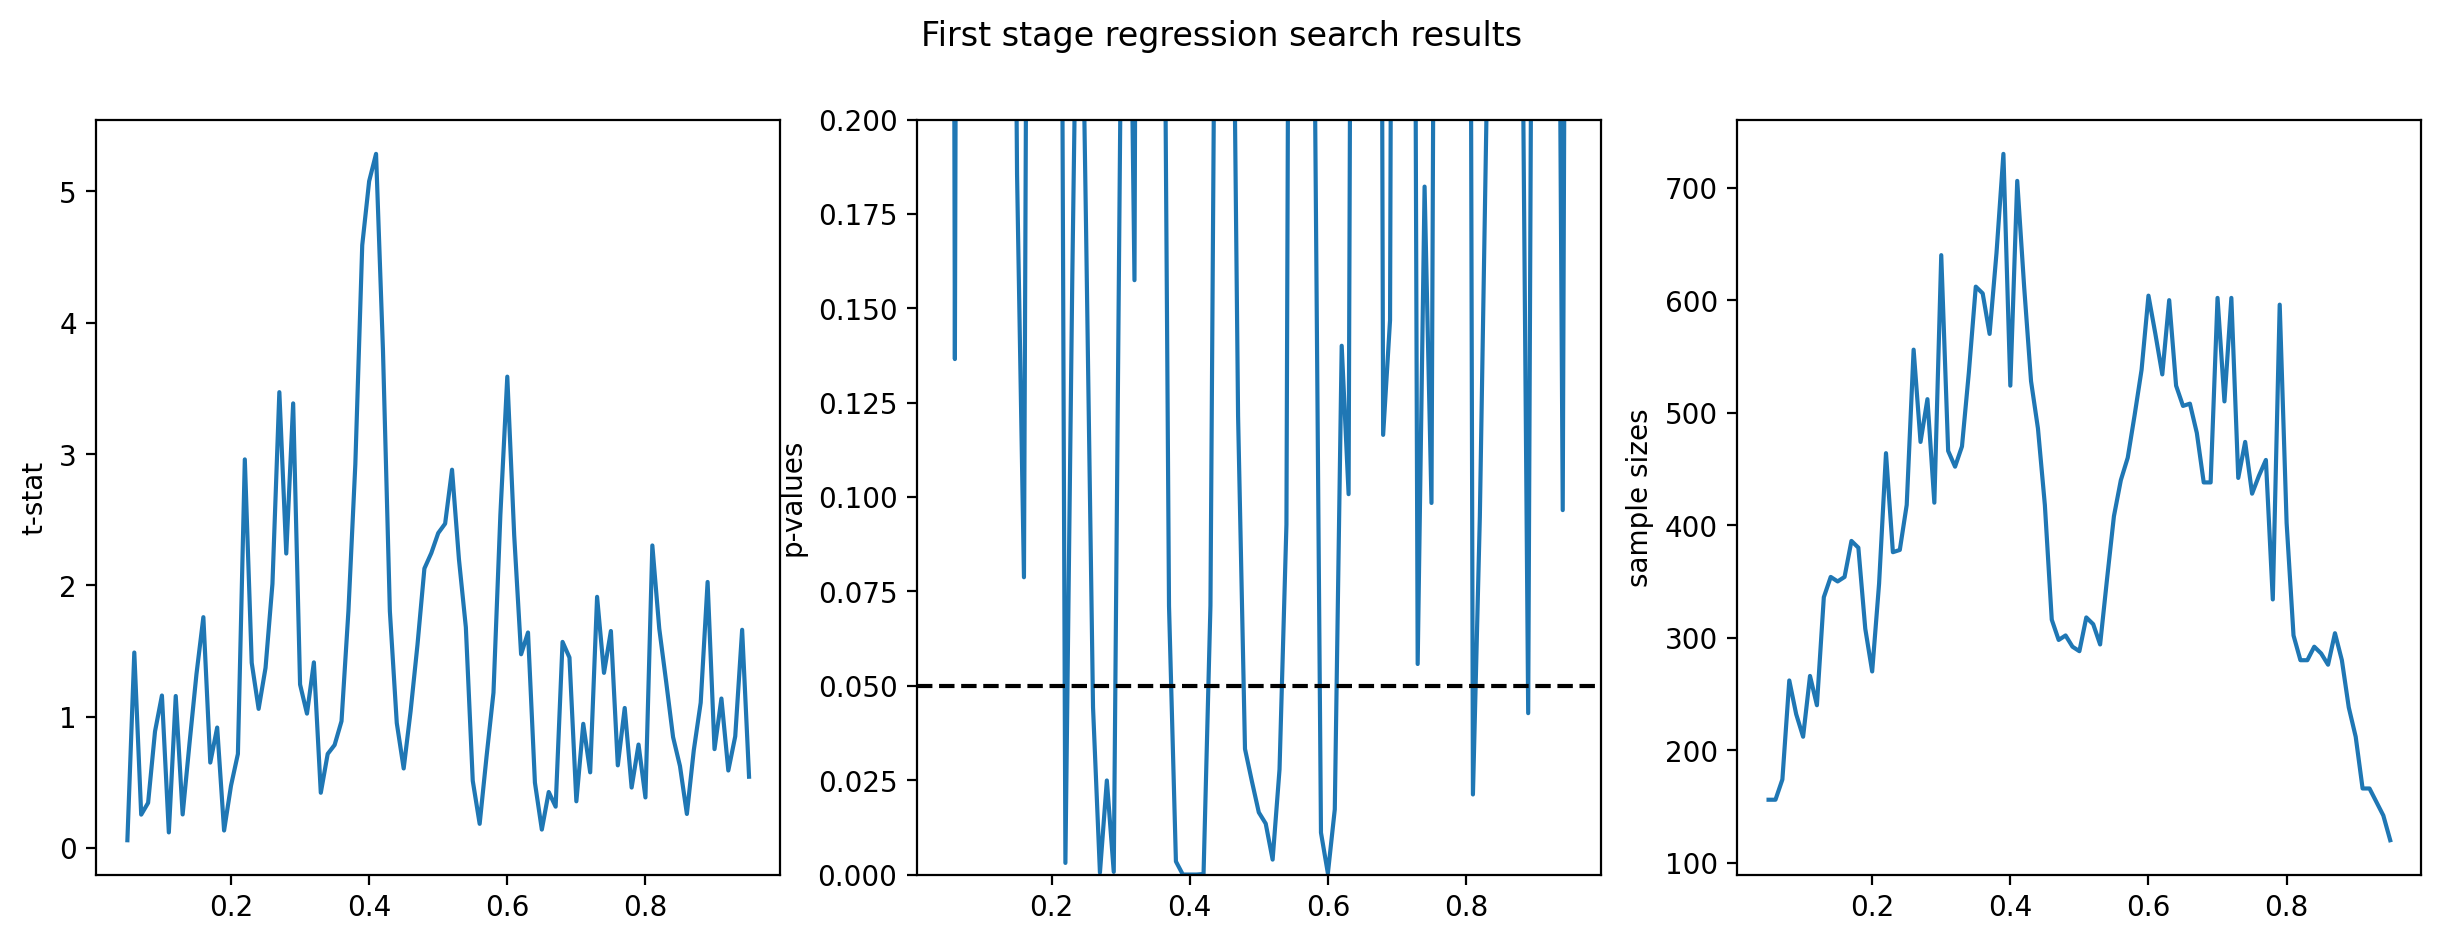

In [43]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5), dpi=200)

sns.lineplot(cutoffs, np.abs(tstats), ax=ax1)
ax1.set_ylabel("t-stat")
sns.lineplot(cutoffs, pvals, ax=ax2)
ax2.set_ylabel("p-values")
ax2.set_ylim(0, 0.2)
ax2.axhline(y=0.05, ls='--', color='black')
sns.lineplot(cutoffs, ns, ax=ax3)
ax3.set_ylabel("sample sizes")
fig.suptitle("First stage regression search results")

## Multiple comparisons correction

In [46]:
corr_pval = 0.05 / len(cutoffs)

In [48]:
cutoffs[np.argwhere(np.array(pvals) < corr_pval)]

array([[0.27],
       [0.39],
       [0.4 ],
       [0.41],
       [0.42],
       [0.6 ]])

- questions here:
    - how to control for false positives?
    - how to merge close cutoffs?

- hardcoded for now, extraction of 0.27, 0.4, 0.6 cutoff candidates

## Learn compliance per cutoff

In [49]:
blend_df.head()

,x,z,t,y,p,u,x_lower,x_upper,p_compliance,cat
0,0.259423,0,0,-0.653786,0.070277,0.018393,-0.240577,-0.000000,0.929723,0
1,0.466311,0,0,0.489816,0.180845,0.087583,-0.033689,-0.000000,0.819155,0
2,0.063955,0,1,-1.058008,0.035352,0.022561,-0.436045,-0.000000,0.964648,0
3,0.456150,0,0,-0.766106,0.243230,0.151999,-0.043850,-0.000000,0.756770,0
4,0.652103,1,1,2.185180,0.954632,0.024212,0.000000,0.152103,0.954632,1


### cutoff = 0.4

In [116]:
cutoff = 0.4
grp_df = blend_df.copy()
grp_df['cand_treat'] = (grp_df['x'] > 0.4).astype(int)

In [117]:
grp_df['cand_comply'] = grp_df['cand_treat'] == grp_df['t']

In [118]:
n_splits = 2

kfold = StratifiedKFold(n_splits=n_splits,
             shuffle=True, random_state=42)

indices = []

for train_idx, test_idx in kfold.split(grp_df, y=grp_df['cand_comply']):
    indices.append(test_idx)
    
# TODO, need to investigate whether 2 splits are needed
s1_df = grp_df.iloc[indices[0]].copy()
s2_df = grp_df.iloc[indices[1]].copy()

In [119]:
tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(s1_df[['cat']], s1_df['cand_comply'])

DecisionTreeClassifier(max_depth=2)

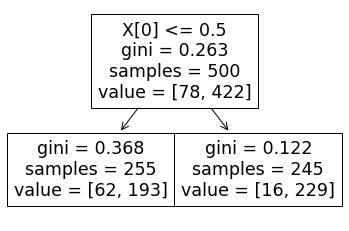

In [120]:
from sklearn import tree
tree.plot_tree(tree_clf)
plt.show()

In [121]:
tree_clf.score(s2_df[['cat']], s2_df['cand_comply'])

0.842

### cutoff = 0.6

In [122]:
cutoff = 0.6
grp_df = blend_df.copy()
grp_df['cand_treat'] = (grp_df['x'] > cutoff).astype(int)

In [123]:
grp_df['cand_comply'] = grp_df['cand_treat'] == grp_df['t']

In [124]:
n_splits = 2

kfold = StratifiedKFold(n_splits=n_splits,
             shuffle=True, random_state=42)

indices = []

for train_idx, test_idx in kfold.split(grp_df, y=grp_df['cand_comply']):
    indices.append(test_idx)
    
# TODO, need to investigate whether 2 splits are needed
s1_df = grp_df.iloc[indices[0]].copy()
s2_df = grp_df.iloc[indices[1]].copy()

In [125]:
tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(s1_df[['cat']], s1_df['cand_comply'])

DecisionTreeClassifier(max_depth=2)

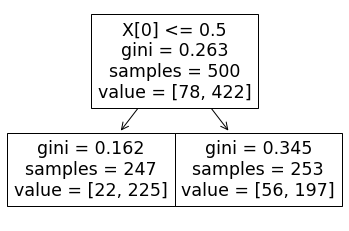

In [126]:
from sklearn import tree
tree.plot_tree(tree_clf)
plt.show()

In [127]:
tree_clf.score(s2_df[['cat']], s2_df['cand_comply'])

0.842

### cutoff = 0.27

In [128]:
cutoff = 0.27
grp_df = blend_df.copy()
grp_df['cand_treat'] = (grp_df['x'] > cutoff).astype(int)

In [129]:
grp_df['cand_comply'] = grp_df['cand_treat'] == grp_df['t']

In [130]:
n_splits = 2

kfold = StratifiedKFold(n_splits=n_splits,
             shuffle=True, random_state=42)

indices = []

for train_idx, test_idx in kfold.split(grp_df, y=grp_df['cand_comply']):
    indices.append(test_idx)
    
# TODO, need to investigate whether 2 splits are needed
s1_df = grp_df.iloc[indices[0]].copy()
s2_df = grp_df.iloc[indices[1]].copy()

In [131]:
tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(s1_df[['cat']], s1_df['cand_comply'])

DecisionTreeClassifier(max_depth=2)

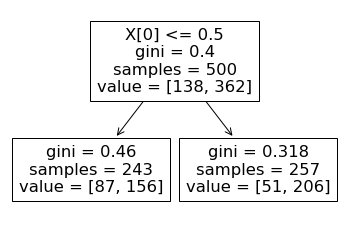

In [132]:
from sklearn import tree
tree.plot_tree(tree_clf)
plt.show()

In [133]:
tree_clf.score(s2_df[['cat']], s2_df['cand_comply'])

0.722

# Blended RDD with continuous indicator

- simulation setup:
    - if age >65, x=0.6
    - if age <=65, x=0.4

## Generate data

In [227]:
n = 500
df1 = gen_fuzzy_rdd(n, 0.8, 0.8, 0.2, seed=0, boundary=0.4)
df2 = gen_fuzzy_rdd(n, 0.8, 0.8, 0.2, seed=0, boundary=0.6)

df1['age'] = np.random.uniform(50, 65, size=n)
df2['age'] = np.random.uniform(65, 80, size=n)

cont_blend_df = df1.append(df2)
cont_blend_df = cont_blend_df.sample(frac=1).reset_index(drop=True)

In [228]:
cont_blend_df

,x,z,t,y,p,u,x_lower,x_upper,p_compliance,age
0,0.456911,0,0,-1.385496,0.121743,0.030360,-0.043089,-0.000000,0.878257,69.462782
1,0.699622,1,1,-0.858547,1.000000,0.067057,0.000000,0.199622,1.000000,64.694966
2,0.777408,1,1,2.194307,0.904452,-0.051029,0.000000,0.277408,0.904452,61.068219
3,0.788546,1,1,-0.786404,0.911275,-0.046434,0.000000,0.288546,0.911275,68.123363
4,0.396060,0,0,1.056555,0.067464,-0.011747,-0.103940,-0.000000,0.932536,77.358233
...,...,...,...,...,...,...,...,...,...,...
995,0.575751,1,1,-0.197984,0.893734,-0.021417,0.000000,0.075751,0.893734,54.839944
996,0.081101,0,0,-1.370057,0.254295,0.238075,-0.418899,-0.000000,0.745705,67.030267
997,0.186193,0,0,-0.335320,0.024133,-0.013105,-0.313807,-0.000000,0.975867,60.060649
998,0.490459,0,0,0.428811,0.032103,-0.065989,-0.009541,-0.000000,0.967897,75.289586


Text(0.5, 1.0, 'density of treated individuals')

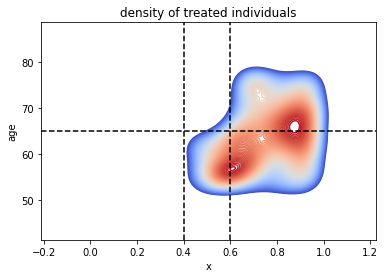

In [258]:
treat_df = cont_blend_df[cont_blend_df['t'] == 1]

sns.kdeplot(treat_df['x'], treat_df['age'],
            levels=100,  
            cmap='coolwarm',
            thresh=0.3,
            #cbar=True,
            #common_norm=True)
           )
plt.axvline(x=0.6, ls='--', color='black')
plt.axvline(x=0.4, ls='--', color='black')
plt.axhline(y=65, ls='--', color='black')
plt.title("density of treated individuals")
#plt.xlim(0,1)
#plt.ylim(0,1)

## Find candidate cutoffs

### True running variable

In [230]:
%%time
cutoffs = np.arange(0.05, 0.96, 0.01)

pvals = []
tstats = []
ns = []
for c in cutoffs:
    t, p, n = test_discontinuity(cont_blend_df, c)
    tstats.append(t)
    pvals.append(p)
    ns.append(n)

CPU times: user 1min 28s, sys: 3.16 s, total: 1min 31s
Wall time: 11.8 s


Text(0.5, 0.98, 'First stage regression search results')

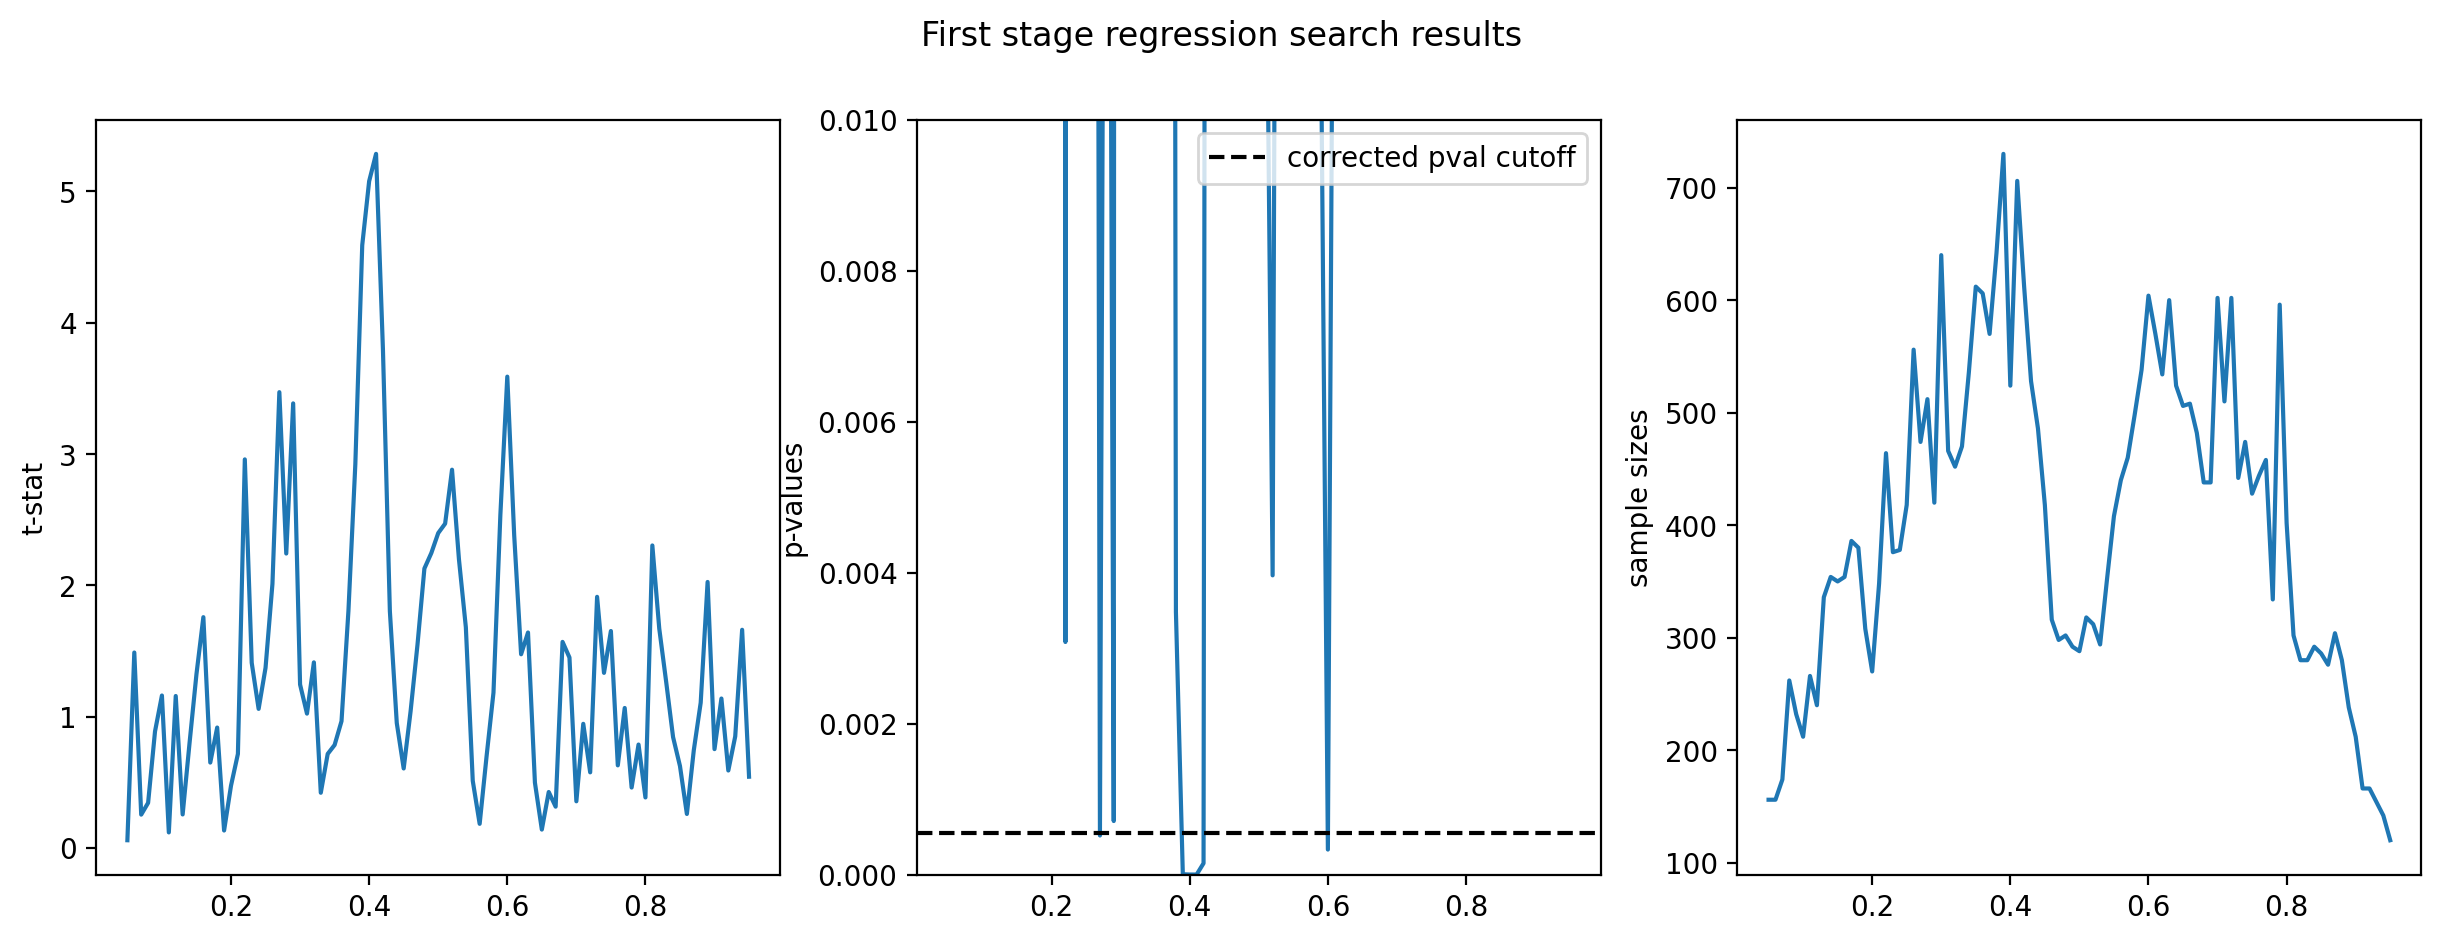

In [231]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5), dpi=200)

sns.lineplot(cutoffs, np.abs(tstats), ax=ax1)
ax1.set_ylabel("t-stat")
sns.lineplot(cutoffs, pvals, ax=ax2)
ax2.set_ylabel("p-values")
ax2.set_ylim(0, 0.01)
ax2.axhline(y=0.05 / len(cutoffs), ls='--', color='black', label="corrected pval cutoff")
sns.lineplot(cutoffs, ns, ax=ax3)
ax3.set_ylabel("sample sizes")
ax2.legend()
fig.suptitle("First stage regression search results")

In [232]:
corr_pval = 0.05 / len(cutoffs)

In [233]:
cutoffs[np.argwhere(np.array(pvals) < corr_pval)]

array([[0.27],
       [0.39],
       [0.4 ],
       [0.41],
       [0.42],
       [0.6 ]])

### Age as running variable

In [234]:
age_test_df = cont_blend_df.copy()
age_test_df['x'] = age_test_df['age']

In [235]:
%%time
cutoffs = np.arange(51, 79, 0.5)

pvals = []
tstats = []
ns = []
for c in cutoffs:
    t, p, n = test_discontinuity(age_test_df, c)
    tstats.append(t)
    pvals.append(p)
    ns.append(n)

CPU times: user 54.5 s, sys: 2 s, total: 56.5 s
Wall time: 7.24 s


Text(0.5, 0.98, 'First stage regression search results')

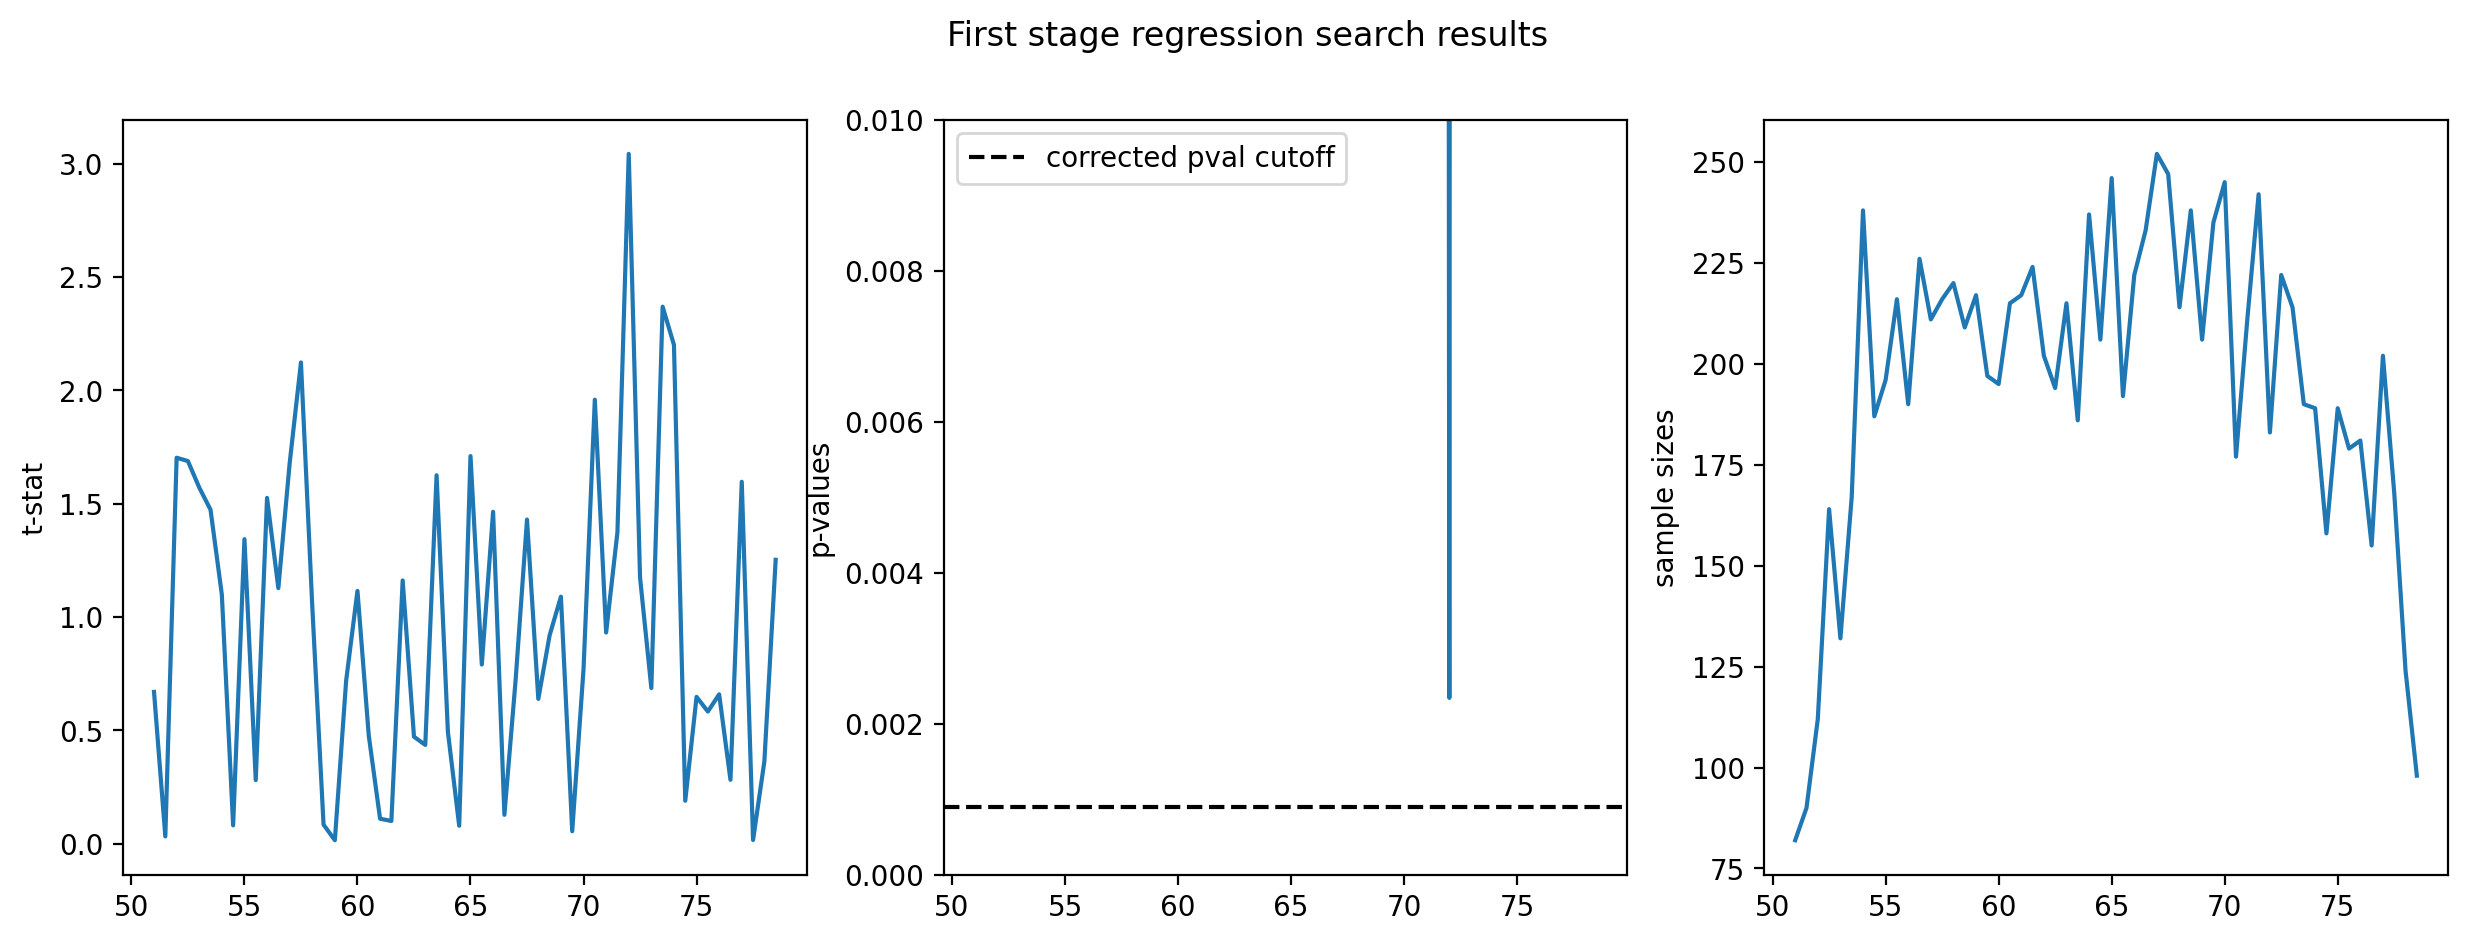

In [236]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5), dpi=200)

sns.lineplot(cutoffs, np.abs(tstats), ax=ax1)
ax1.set_ylabel("t-stat")
sns.lineplot(cutoffs, pvals, ax=ax2)
ax2.set_ylabel("p-values")
ax2.set_ylim(0, 0.01)
ax2.axhline(y=0.05 / len(cutoffs), ls='--', color='black', label="corrected pval cutoff")
sns.lineplot(cutoffs, ns, ax=ax3)
ax3.set_ylabel("sample sizes")
ax2.legend()
fig.suptitle("First stage regression search results")

In [237]:
corr_pval = 0.05 / len(cutoffs)

In [238]:
cutoffs[np.argwhere(np.array(pvals) < corr_pval)]

array([], shape=(0, 1), dtype=float64)

- age does not show up as a potential discontinuity, after multiple corrections

## Learn compliance per cutoff

### cutoff = 0.4

In [239]:
cutoff = 0.4
grp_df = cont_blend_df.copy()
grp_df['cand_treat'] = (grp_df['x'] > cutoff).astype(int)

In [240]:
grp_df['cand_comply'] = grp_df['cand_treat'] == grp_df['t']

In [241]:
n_splits = 2

kfold = StratifiedKFold(n_splits=n_splits,
             shuffle=True, random_state=42)

indices = []

for train_idx, test_idx in kfold.split(grp_df, y=grp_df['cand_comply']):
    indices.append(test_idx)
    
# TODO, need to investigate whether 2 splits are needed
s1_df = grp_df.iloc[indices[0]].copy()
s2_df = grp_df.iloc[indices[1]].copy()

In [242]:
tree_clf = DecisionTreeClassifier(max_depth=2, min_samples_split=10)
tree_clf.fit(s1_df[['age']], s1_df['cand_comply'])

DecisionTreeClassifier(max_depth=2, min_samples_split=10)

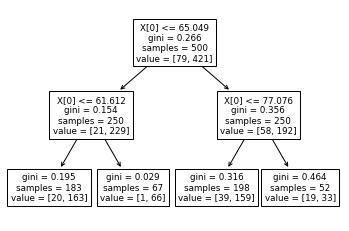

In [243]:
from sklearn import tree
tree.plot_tree(tree_clf)
plt.show()

In [244]:
tree_clf.score(s2_df[['age']], s2_df['cand_comply'])

0.844

### cutoff = 0.6

In [270]:
cutoff = 0.6
grp_df = cont_blend_df.copy()
grp_df['cand_treat'] = (grp_df['x'] > cutoff).astype(int)

In [271]:
grp_df['cand_comply'] = grp_df['cand_treat'] == grp_df['t']

In [272]:
n_splits = 2

kfold = StratifiedKFold(n_splits=n_splits,
             shuffle=True, random_state=55)

indices = []

for train_idx, test_idx in kfold.split(grp_df, y=grp_df['cand_comply']):
    indices.append(test_idx)
    
# TODO, need to investigate whether 2 splits are needed
s1_df = grp_df.iloc[indices[0]].copy()
s2_df = grp_df.iloc[indices[1]].copy()

In [273]:
tree_clf = DecisionTreeClassifier(max_depth=2, min_samples_split=50)
tree_clf.fit(s1_df[['age']], s1_df['cand_comply'])

DecisionTreeClassifier(max_depth=2, min_samples_split=50)

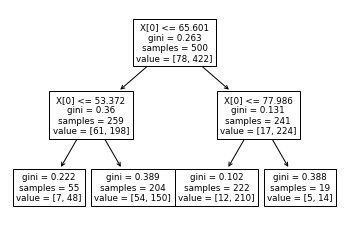

In [274]:
from sklearn import tree
tree.plot_tree(tree_clf)
plt.show()

In [268]:
tree_clf.score(s2_df[['age']], s2_df['cand_comply'])

0.842

### cutoff = 0.27

In [251]:
cutoff = 0.27
grp_df = cont_blend_df.copy()
grp_df['cand_treat'] = (grp_df['x'] > cutoff).astype(int)

In [252]:
grp_df['cand_comply'] = grp_df['cand_treat'] == grp_df['t']

In [253]:
n_splits = 2

kfold = StratifiedKFold(n_splits=n_splits,
             shuffle=True, random_state=42)

indices = []

for train_idx, test_idx in kfold.split(grp_df, y=grp_df['cand_comply']):
    indices.append(test_idx)
    
# TODO, need to investigate whether 2 splits are needed
s1_df = grp_df.iloc[indices[0]].copy()
s2_df = grp_df.iloc[indices[1]].copy()

In [254]:
tree_clf = DecisionTreeClassifier(max_depth=2, min_samples_split=10)
tree_clf.fit(s1_df[['age']], s1_df['cand_comply'])

DecisionTreeClassifier(max_depth=2, min_samples_split=10)

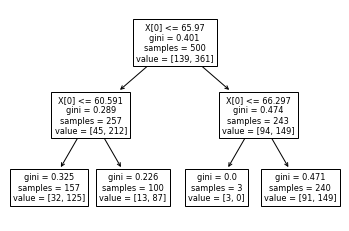

In [255]:
from sklearn import tree
tree.plot_tree(tree_clf)
plt.show()

In [256]:
tree_clf.score(s2_df[['age']], s2_df['cand_comply'])

0.726

- will be hard to differentiate between "valid" and invalid splits, but we see that the false positive cutoff produces a tree with lower accuracy than the other two
- could potentially estimate the study power at every node? This would allow us to know when to stop walking down the tree